In [4]:
import pandas as pd
import mne as mne
import os 
import time
import numpy as np
import matplotlib.pyplot as plt
import joblib
import constants
from IPython.utils import io
import time
import sys
import yasa
from scipy.signal import welch

## Use decision tree as a rough way for splitting based on that feature
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import balanced_accuracy_score
from sklearn import tree

#Import my modules
import format_eeg_data
import constants
import eeg_stat_ts
import run_expts

pd.set_option('display.max_columns', 80)
pd.set_option('display.max_rows', 80)

#### Load the PSD Data and take a single region (Central)

In [50]:
data_type = 'N1'
df = joblib.load(os.path.join(os.path.abspath('..'), data_type + '_psd_normalised_data.pkl') )

single_region_df = df[[col for col in df.columns if col.endswith('_Central')]]
frequency_vals  = np.arange(0.5,40.125, 0.125)
single_region_df.columns = frequency_vals

folder = '/user/home/ko20929/work/RBD_using_custom_package/Blue_pebble/'
paths = joblib.load(folder + data_type + '_paths.pkl')

groups = pd.Series(paths['s_p_id'])
s_class_list = pd.Series(paths['s_class_list'])
y = s_class_list.map({'HC': 0 , 'PD' : 1 , 'PD+RBD' : 2 , 'RBD' : 3})

In [51]:
width_slide_list = [(0.5,0.5)] 

for window_width in range(1, 15 ):
    width_slide_list.append((window_width, 0.5) )

#### Set the window width in hz and window slide in hz

In [24]:
best_feat_1 = feature_dfs[1][['2.5_width_1']].copy()
best_feat_2 = feature_dfs[3][['10.0_width_3']].copy()

In [40]:
best_two_feats = feats_dict[2][1][['2.5_width_1' , '9.0_width_1']].copy()

In [52]:
t3 = time.time()
previous_best_feat = best_two_feats.copy()

results_dfs = []
feature_dfs = []

# To save the feature dataframes 
feats_dict  = {}
j = 0 #counter to populate feature dict dataframes

for window_width_hz, window_slide_hz in width_slide_list:
    j+=1
    
    feats_dict[j] = []

    description = 'window width : ' + str(window_width_hz) + ' .  window stride : ' + str(window_slide_hz)

    feats_dict[j].append(description)

    
    #1.Set Window width in Hz and Window Slide in Hz
    # window_width_hz = 3
    window_len = (window_width_hz/0.125)+1
    assert window_len%1 == 0
    window_len = int(window_len)
    
    # window_slide_hz = 0.5 
    window_slide_len = window_slide_hz/0.125 
    assert window_slide_len%1 == 0
    window_slide_len = int(window_slide_len)
    
    
    #2.Calculate band values and store in dataframe calculated_df
    
    # Start of the window is the middle_freq value minus window_width_hz/2 
    # End of the window is the middle freq value plus window_width_hz/2
    window_len
    
    middle_freq = []
    final_cols = []
    
    i = 0
    while i < len(frequency_vals) - window_len:
        middle_freq.append( frequency_vals[i:i+window_len].mean() )
        band_vals = single_region_df.iloc[:,i:i+window_len].mean(axis = 1) #For every row calculate the mean for the appropriate elements
        
        final_cols.append(band_vals)
        
        # scaled_psd.append( psd_values[i:i+factor].mean() )
        i+= window_slide_len
    
    calculated_df = pd.DataFrame(final_cols).T
    calculated_df.columns = middle_freq
    
    calculated_df.columns = [ str(col) + '_width_' + str(window_width_hz) for col in calculated_df.columns]
    
    
    #3.Calculate Information Gain Based on Features
    #Change to binary HC vs PD / PD+RBD ---> Generate expt specific X,y,groups 
    expt_num = 1
    X_expt , y_expt , groups_expt, expt_info = run_expts.generate_expt_x_y_groups(calculated_df,y,groups,expt_num)

    feature_dfs.append(X_expt)
    feats_dict[j].append(X_expt)
    
    # Calculate a score for each feature (Band) -> How well does a decision tree of depth 1 split based on only that feature
    scores_dict = {}
    for col in X_expt.columns:
        two_feats_df = pd.concat( [X_expt[[col]], previous_best_feat] , axis = 1)
        DT = DecisionTreeClassifier(max_depth=3, random_state = 5)
        DT.fit(two_feats_df, y_expt)
        # score = balanced_accuracy_score(y_expt,  DT.predict(two_feats_df))
        score = accuracy_score(y_expt,  DT.predict(two_feats_df))
        scores_dict[col] = score
    
    #3.Create scores dataframe -> df_results
    df_results = pd.DataFrame(list(scores_dict.items()), columns=['Index', 'Score'])
    df_results.set_index('Index', inplace=True)
    df_results = df_results.sort_values(by = 'Score' , ascending  = False)
    results_dfs.append(df_results)

#Concatenate the features and scores into a single dataframe
dfs_to_concat = []
concat_cols = []

counter = 0
for df in results_dfs:
    counter+=1
    df = df.reset_index()
    df.columns = [col + '_' + str(int(counter)) for col in df.columns]
    concat_cols+= list(df.columns)
    dfs_to_concat.append(df)

concat_df = pd.concat(dfs_to_concat, ignore_index = True , axis = 1)
concat_df.columns = concat_cols


t4 = time.time()
t4-t3

ValueError: Number of labels=40 does not match number of samples=42

In [42]:
concat_df

,Index_1,Score_1,Index_2,Score_2,Index_3,Score_3,Index_4,Score_4,Index_5,Score_5,Index_6,Score_6,Index_7,Score_7,Index_8,Score_8,Index_9,Score_9,Index_10,Score_10,Index_11,Score_11,Index_12,Score_12,Index_13,Score_13,Index_14,Score_14,Index_15,Score_15
0,12.75_width_0.5,0.950,13.0_width_1,0.950,12.5_width_2,0.950,13.0_width_3,0.950,13.0_width_4,0.950,37.0_width_5,0.925,3.5_width_6,0.925,4.0_width_7,0.925,35.5_width_8,0.925,35.0_width_9,0.925,34.5_width_10,0.925,34.0_width_11,0.925,33.5_width_12,0.925,33.0_width_13,0.925,32.5_width_14,0.925
1,12.25_width_0.5,0.950,12.5_width_1,0.950,13.0_width_2,0.950,38.0_width_3,0.925,37.5_width_4,0.925,29.0_width_5,0.925,15.5_width_6,0.925,30.5_width_7,0.925,12.5_width_8,0.925,12.5_width_9,0.925,28.5_width_10,0.925,29.0_width_11,0.925,29.0_width_12,0.925,30.0_width_13,0.925,30.0_width_14,0.925
2,0.75_width_0.5,0.925,1.0_width_1,0.925,29.5_width_2,0.925,14.0_width_3,0.925,29.0_width_4,0.925,13.5_width_5,0.925,26.0_width_6,0.925,26.0_width_7,0.925,25.5_width_8,0.925,25.5_width_9,0.925,26.0_width_10,0.925,26.5_width_11,0.925,16.0_width_12,0.925,27.5_width_13,0.925,27.5_width_14,0.925
3,31.25_width_0.5,0.925,31.5_width_1,0.925,14.0_width_2,0.925,14.5_width_3,0.925,14.0_width_4,0.925,14.0_width_5,0.925,26.5_width_6,0.925,26.5_width_7,0.925,26.0_width_8,0.925,26.0_width_9,0.925,26.5_width_10,0.925,16.0_width_11,0.925,15.5_width_12,0.925,28.0_width_13,0.925,28.0_width_14,0.925
4,25.25_width_0.5,0.925,26.0_width_1,0.925,14.5_width_2,0.925,15.0_width_3,0.925,14.5_width_4,0.925,14.5_width_5,0.925,27.0_width_6,0.925,27.0_width_7,0.925,26.5_width_8,0.925,26.5_width_9,0.925,27.0_width_10,0.925,15.5_width_11,0.925,15.0_width_12,0.925,28.5_width_13,0.925,28.5_width_14,0.925
5,25.75_width_0.5,0.925,26.5_width_1,0.925,15.0_width_2,0.925,15.5_width_3,0.925,15.0_width_4,0.925,15.0_width_5,0.925,27.5_width_6,0.925,27.5_width_7,0.925,27.0_width_8,0.925,27.0_width_9,0.925,16.0_width_10,0.925,15.0_width_11,0.925,26.5_width_12,0.925,29.0_width_13,0.925,29.5_width_14,0.925
6,26.25_width_0.5,0.925,27.0_width_1,0.925,15.5_width_2,0.925,31.0_width_3,0.925,15.5_width_4,0.925,15.5_width_5,0.925,28.0_width_6,0.925,28.0_width_7,0.925,27.5_width_8,0.925,27.5_width_9,0.925,15.5_width_10,0.925,14.5_width_11,0.925,27.5_width_12,0.925,29.5_width_13,0.925,29.0_width_14,0.925
7,26.75_width_0.5,0.925,27.5_width_1,0.925,31.5_width_2,0.925,30.5_width_3,0.925,30.5_width_4,0.925,29.5_width_5,0.925,28.5_width_6,0.925,28.5_width_7,0.925,28.0_width_8,0.925,28.0_width_9,0.925,15.0_width_10,0.925,14.0_width_11,0.925,28.0_width_12,0.925,27.0_width_13,0.925,30.5_width_14,0.925
8,27.25_width_0.5,0.925,28.0_width_1,0.925,31.0_width_2,0.925,30.0_width_3,0.925,30.0_width_4,0.925,28.5_width_5,0.925,29.0_width_6,0.925,29.0_width_7,0.925,28.5_width_8,0.925,16.0_width_9,0.925,14.5_width_10,0.925,27.5_width_11,0.925,28.5_width_12,0.925,30.5_width_13,0.925,31.0_width_14,0.925
9,27.75_width_0.5,0.925,28.5_width_1,0.925,30.5_width_2,0.925,29.5_width_3,0.925,29.5_width_4,0.925,12.0_width_5,0.925,29.5_width_6,0.925,29.5_width_7,0.925,16.0_width_8,0.925,15.5_width_9,0.925,14.0_width_10,0.925,28.0_width_11,0.925,27.0_width_12,0.925,31.5_width_13,0.925,31.5_width_14,0.925


In [39]:
feats_dict[2][1][['2.5_width_1' , '9.0_width_1']]

,2.5_width_1,9.0_width_1
0,0.010888,0.004107
1,0.011157,0.004142
2,0.017276,0.004070
3,0.011494,0.004144
4,0.012409,0.003933
5,0.014606,0.002583
6,0.015612,0.002569
7,0.013537,0.004457
8,0.014182,0.004184
9,0.018498,0.002614


In [ ]:
# '2.5_width_1' + '9.0_width_1' ---> 90% accuracy  

In [36]:
concat_df

,Index_1,Score_1,Index_2,Score_2,Index_3,Score_3,Index_4,Score_4,Index_5,Score_5,Index_6,Score_6,Index_7,Score_7,Index_8,Score_8,Index_9,Score_9,Index_10,Score_10,Index_11,Score_11,Index_12,Score_12,Index_13,Score_13,Index_14,Score_14,Index_15,Score_15
0,1.25_width_0.5,0.875,12.5_width_1,0.850,1.5_width_2,0.850,12.5_width_3,0.850,12.5_width_4,0.850,12.5_width_5,0.850,12.5_width_6,0.850,13.0_width_7,0.850,13.0_width_8,0.850,13.0_width_9,0.850,13.5_width_10,0.850,16.0_width_11,0.850,16.0_width_12,0.850,7.0_width_13,0.825,7.5_width_14,0.825
1,12.75_width_0.5,0.850,7.5_width_1,0.850,8.0_width_2,0.850,8.0_width_3,0.850,8.0_width_4,0.850,13.5_width_5,0.850,13.5_width_6,0.850,13.5_width_7,0.850,14.0_width_8,0.850,13.5_width_9,0.850,16.0_width_10,0.850,15.5_width_11,0.850,15.5_width_12,0.850,27.0_width_13,0.825,8.0_width_14,0.825
2,10.25_width_0.5,0.850,15.0_width_1,0.850,2.0_width_2,0.850,14.5_width_3,0.850,13.5_width_4,0.850,14.0_width_5,0.850,14.0_width_6,0.850,12.5_width_7,0.850,14.5_width_8,0.850,12.5_width_9,0.850,15.5_width_10,0.850,15.0_width_11,0.850,15.0_width_12,0.850,20.5_width_13,0.825,21.0_width_14,0.825
3,11.25_width_0.5,0.850,14.5_width_1,0.850,15.5_width_2,0.850,14.0_width_3,0.850,13.0_width_4,0.850,12.0_width_5,0.850,12.0_width_6,0.850,12.0_width_7,0.850,12.5_width_8,0.850,14.5_width_9,0.850,15.0_width_10,0.850,14.5_width_11,0.850,6.5_width_12,0.825,21.0_width_13,0.825,21.5_width_14,0.825
4,11.75_width_0.5,0.850,14.0_width_1,0.850,15.0_width_2,0.850,13.5_width_3,0.850,15.0_width_4,0.850,11.5_width_5,0.850,11.5_width_6,0.850,14.5_width_7,0.850,12.0_width_8,0.850,15.0_width_9,0.850,14.5_width_10,0.850,14.0_width_11,0.850,20.5_width_12,0.825,21.5_width_13,0.825,22.0_width_14,0.825
5,8.25_width_0.5,0.850,13.5_width_1,0.850,14.5_width_2,0.850,13.0_width_3,0.850,12.0_width_4,0.850,14.5_width_5,0.850,14.5_width_6,0.850,15.0_width_7,0.850,15.0_width_8,0.850,15.5_width_9,0.850,14.0_width_10,0.850,6.0_width_11,0.825,21.5_width_12,0.825,22.0_width_13,0.825,22.5_width_14,0.825
6,7.75_width_0.5,0.850,13.0_width_1,0.850,14.0_width_2,0.850,12.0_width_3,0.850,11.5_width_4,0.850,15.0_width_5,0.850,15.0_width_6,0.850,15.5_width_7,0.850,15.5_width_8,0.850,16.0_width_9,0.850,5.5_width_10,0.825,27.0_width_11,0.825,22.0_width_12,0.825,22.5_width_13,0.825,23.0_width_14,0.825
7,7.25_width_0.5,0.850,12.0_width_1,0.850,13.5_width_2,0.850,11.5_width_3,0.850,11.0_width_4,0.850,15.5_width_5,0.850,15.5_width_6,0.850,16.0_width_7,0.850,16.0_width_8,0.850,14.0_width_9,0.850,22.0_width_10,0.825,22.0_width_11,0.825,22.5_width_12,0.825,23.0_width_13,0.825,23.5_width_14,0.825
8,12.25_width_0.5,0.850,11.5_width_1,0.850,13.0_width_2,0.850,11.0_width_3,0.850,15.5_width_4,0.850,8.5_width_5,0.850,13.0_width_6,0.850,14.0_width_7,0.850,13.5_width_8,0.850,26.5_width_9,0.825,22.5_width_10,0.825,22.5_width_11,0.825,23.0_width_12,0.825,23.5_width_13,0.825,24.0_width_14,0.825
9,13.25_width_0.5,0.850,11.0_width_1,0.850,12.0_width_2,0.850,10.5_width_3,0.850,14.5_width_4,0.850,13.0_width_5,0.850,27.5_width_6,0.825,27.0_width_7,0.825,27.0_width_8,0.825,27.5_width_9,0.825,23.0_width_10,0.825,23.0_width_11,0.825,23.5_width_12,0.825,24.0_width_13,0.825,24.5_width_14,0.825


#### Do a plot based on the best two features to see how good they are

In [68]:
#Decent for N1 plt.scatter(feats_dict[3][1]['4.0_width_2'], feats_dict[4][1]['2.5_width_3'] , c = y_expt.values )

In [59]:
len(feats_dict[1][1]['0.75_width_0.5'])

40

In [60]:
0.05*40

2.0

In [53]:
len(feats_dict[2][1]['2.5_width_1'])

KeyError: 2

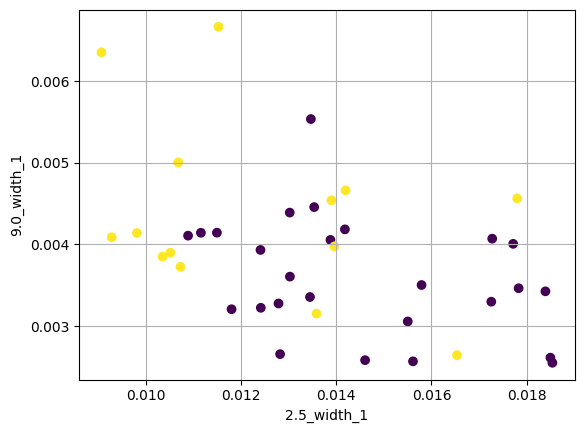

In [34]:
plt.scatter(feats_dict[2][1]['2.5_width_1'], feats_dict[2][1]['9.0_width_1'] , c = y_expt.values )
plt.xlabel('2.5_width_1')
plt.ylabel('9.0_width_1')
plt.grid()

### 3D-Plot

In [44]:
import random

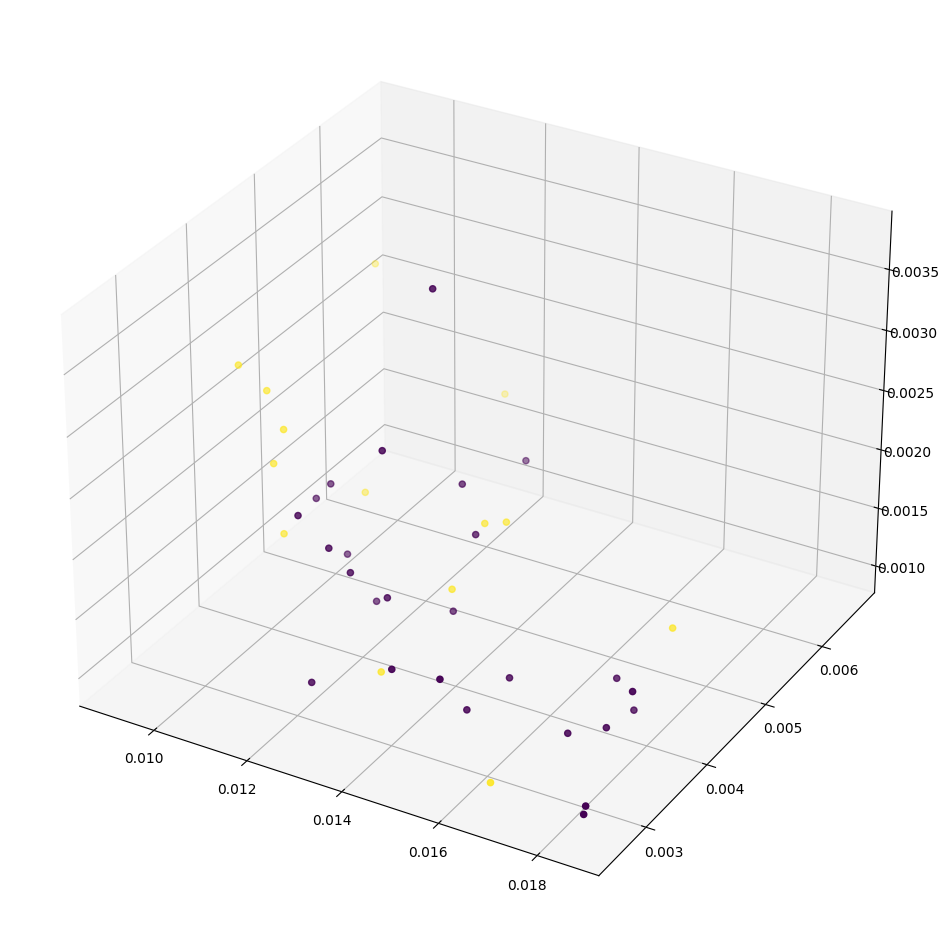

In [49]:
fig = plt.figure(figsize=(12, 12))
ax = fig.add_subplot(projection='3d')

ax.scatter(feats_dict[2][1]['2.5_width_1'], feats_dict[2][1]['9.0_width_1'], feats_dict[4][1]['13.0_width_3'] , c = y_expt.values)
plt.show()

https://stackoverflow.com/questions/4739360/any-easy-way-to-plot-a-3d-scatter-in-python-that-i-can-rotate-around